In [9]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from collections import defaultdict

from pathlib import Path
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
import pickle

In [10]:
base_dir = Path('/mnt/cocodata/')
annotations_path = base_dir / 'annotations'
test_annotations_path = annotations_path / 'test.json'
annotations_output_path = base_dir / 'outputf'
figures = base_dir / 'figures'
os.listdir(annotations_output_path)

['17_06_V1_retinanet_FAS_d18_lr0.04_ti300_vi30_seed0_sample25.json',
 '09_05_V1_retinanet_RSB_d18_lr0.04_ti300_vi30_seed0_sample35.json',
 '17_06_V1_retinanet_FAS_d18_lr0.04_ti300_vi30_seed3_sample15.json',
 '02_06_V1_retinanet_FAD_d18_lr0.04_ti300_vi30_seed1_sample10.json',
 '15_06_V1_retinanet_ACM_d18_lr0.04_ti300_vi30_seed1_sample65.json',
 '15_06_V1_retinanet_ACM_d18_lr0.04_ti300_vi30_seed1_sample50.json',
 '27_05_V1_retinanet_RCM_d18_lr0.04_ti300_vi30_seed4_sample85.json',
 '11_05_V1_retinanet_BAM_d18_lr0.04_ti300_vi30_seed3_sample10.json',
 '09_05_V1_retinanet_RSB_d18_lr0.04_ti300_vi30_seed3_sample10.json',
 '02_06_V1_retinanet_FA1_d18_lr0.04_ti300_vi30_seed1_sample25.json',
 '04_06_V1_retinanet_ASD_d18_lr0.04_ti300_vi30_seed0_sample25.json',
 '15_06_V1_retinanet_BCM_d18_lr0.04_ti300_vi30_seed2_sample35.json',
 '09_05_V1_retinanet_RSB_d18_lr0.04_ti300_vi30_seed3_sample50.json',
 '11_06_V1_retinanet_SRM_d18_lr0.04_ti300_vi30_seed1_sample5.json',
 '27_05_V1_retinanet_RCM_d18_lr0.04

In [11]:
coco_true = COCO(test_annotations_path)
all_methods = ['SUM']
standard_sample_space = [5, 10,15, 25, 35, 50, 65, 85]
coco_outputs = ['Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100]',
 'Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ]',
 'Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ]',
 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]',
 'Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]',
 'Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]',
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ]',
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ]',
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ]',
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ]',
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ]',
 'Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ]']

def coco_stats(json_output_path):
    #opens json files
    results = []
    with open(json_output_path, "r") as file:
        output = json.load(file)
    coco_pred = coco_true.loadRes(output["annotations"])
    coco_eval = COCOeval(coco_true, coco_pred, 'bbox')
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    return coco_eval.stats
    
def coco_list(json_output_paths):
    results = []
    for json_output_path in json_output_paths:
        results.append(list(coco_stats(json_output_path)))
    return results

def coco_organize(output_filter, methods = all_methods, sample_space = standard_sample_space):
    outputs = [output for output in os.listdir(annotations_output_path) if output_filter in output]
    print(len(outputs))
    method_dict = defaultdict(lambda: defaultdict(list))
    for method in methods:
        method_dict[method]['files'] = [output for output in outputs if method in output]
        counter = 0
        for sample_size in sample_space:
            print(method , counter , " / " , len(sample_space))
            counter += 1
            sample_str = 'sample' + str(sample_size) + '.json'
            sample_jsons = [str(annotations_output_path / output) for output in method_dict[method]['files'] if sample_str in output]
            coco_outputs = coco_list(sample_jsons)
            method_dict[method][sample_size] = [list(np.mean(coco_outputs, axis=0)), list(stats.sem(coco_outputs))]
    
    return method_dict

def coco_plotter(data, methods = all_methods, sample_space = standard_sample_space, plots = coco_outputs, set_y=None):
    fig, axes = plt.subplots(nrows=len(plots))
    fig.set_figheight(70)
    fig.subplots_adjust(hspace=.5)
    print(data)
    if set_y:
        y_space = list(np.arange(0, 1, 0.1))
    for i, plot in enumerate(plots):
        for method in methods:
            means = []
            std_errs = []
            for sample_size in sample_space:
                means.append(data[method][sample_size][0][i])
                std_errs.append(data[method][sample_size][1][i])
            axes[i].errorbar(sample_space, means, std_errs, label=method)
        axes[i].set_xticks(sample_space)
        if set_y:
            axes[i].set_yticks(y_space)
        axes[i].legend()
        axes[i].set(title = plot)
    plt.savefig(str(figures / 'test'))

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


39
SUM 0  /  8
Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.78s).
Accumulating evaluation results...
DONE (t=0.16s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.53269
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.88578
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.58328
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.22858
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.54858
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05486
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.41989
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.61809
 Average Recall     (AR) @[ IoU=0

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.69s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.52423
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.86723
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.57258
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.17930
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.54250
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.41925
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.61103
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.82s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.52921
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.87201
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.59377
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.21815
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.54672
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05565
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.42154
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.61861
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=11.81s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.53909
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.87998
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.60736
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.21133
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.55695
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05598
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.42574
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.62311
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

Loading and preparing results...
DONE (t=0.03s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.13s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.54809
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.88674
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.61337
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.23704
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.56521
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05640
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.42698
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.62931
 Average Recall     (AR) @[ IoU=0.50:0.95 | area

SUM 7  /  8
Loading and preparing results...
DONE (t=0.08s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=12.21s).
Accumulating evaluation results...
DONE (t=0.18s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.53520
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.88308
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.59216
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.21428
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.55358
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = -1.00000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.05561
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.42019
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.61816
 Average Recall     (AR) @[ IoU=0.50

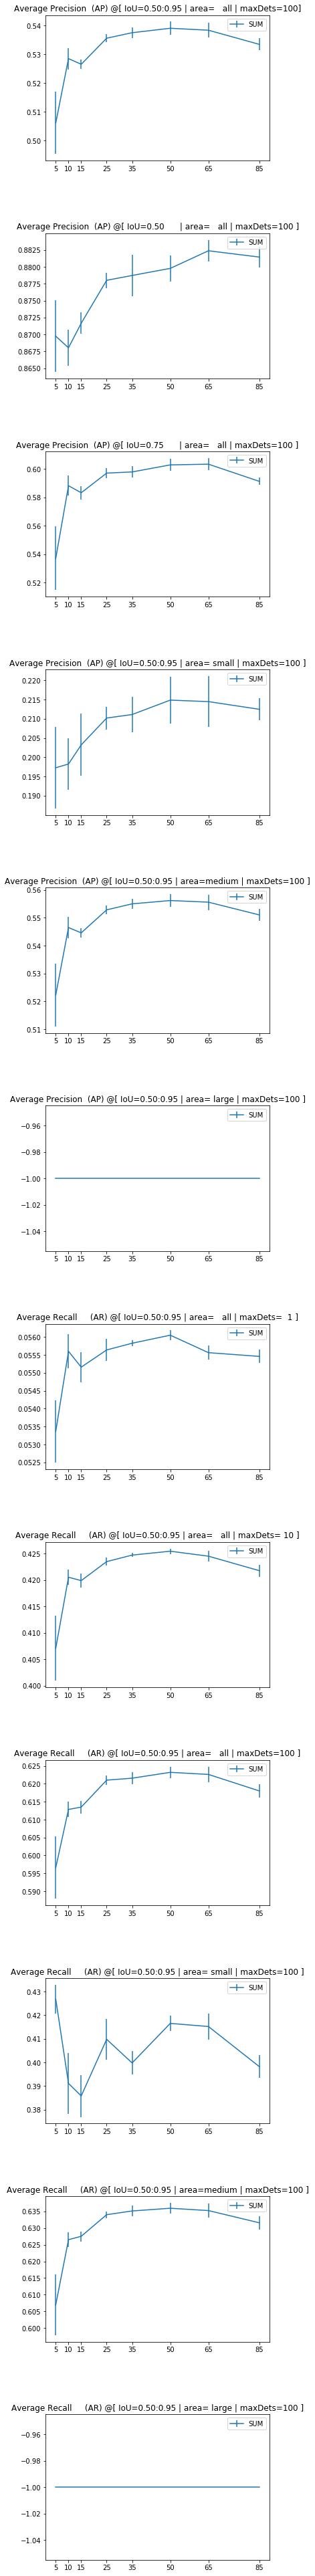

In [13]:
run09_05_V1 = coco_organize('V3')
coco_plotter(run09_05_V1)

{'RSB': {5: [[0.5101195431087362, 0.8729403143996297, 0.5492673531229908, 0.18984100408477814, 0.5279859258466566, -1.0, 0.0545140712945591, 0.4085328330206379, 0.6018686679174484, 0.44228915662650603, 0.6119840637450199, -1.0], [0.01103459932323635, 0.00878182741956049, 0.01913640658027163, 0.01633386609041229, 0.010993886340655616, 0.0, 0.0007365883287285377, 0.004554914346229188, 0.008870193292809974, 0.006322144938286344, 0.009057481308360905, 0.0]], 10: [[0.5210378163256649, 0.8723423777621608, 0.5740392054562484, 0.1922269060501085, 0.5400438518751643, -1.0, 0.05488930581613508, 0.41737335834896816, 0.610108818011257, 0.3619277108433735, 0.6256254980079682, -1.0], [0.003624781446784477, 0.00455935989670168, 0.005147121894624674, 0.012153454996005193, 0.0033542731174170406, 0.0, 0.0002630391319823163, 0.0017508621305752053, 0.002568879760954698, 0.008013180461709178, 0.0023914473301769866, 0.0]], 15: [[0.5300556764362995, 0.8786982549087192, 0.5881319858679909, 0.20548540827679815

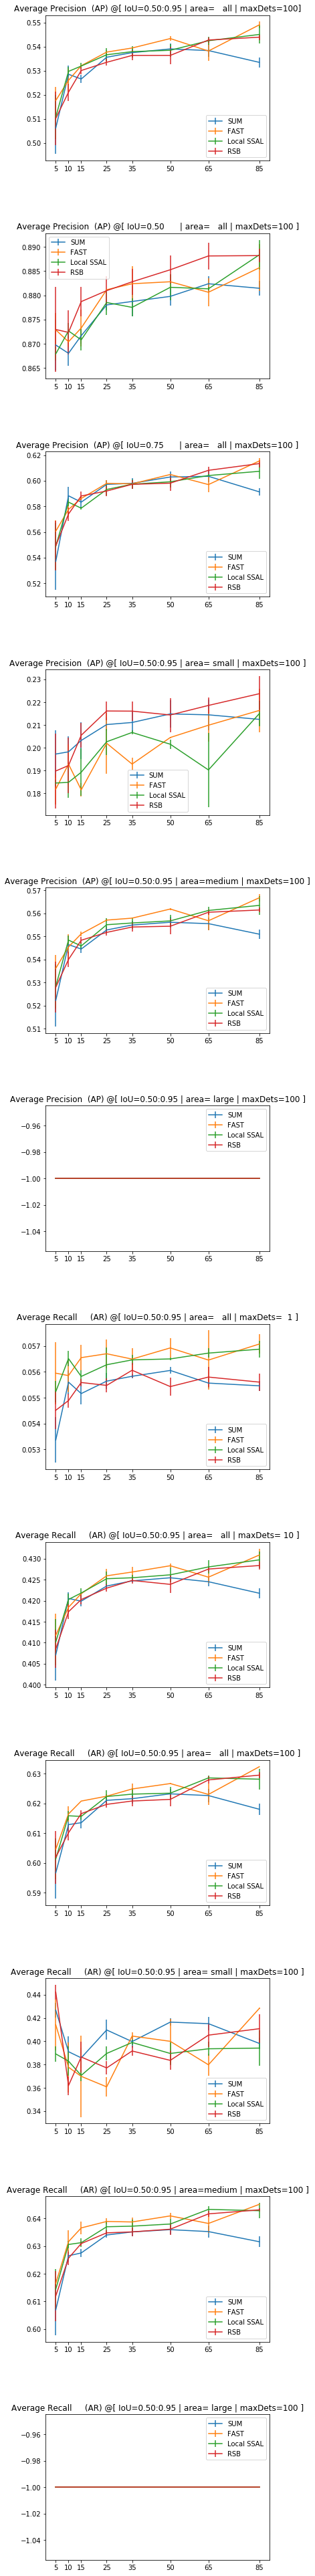

In [15]:
nan = 0
SRM = {5: [[0.4876408420284288, 0.841617901247113, 0.5140251250748045, 0.1693686492093784, 0.5047825570515234, -1.0, 0.05413883677298311, 0.4005028142589119, 0.5800525328330207, 0.4072289156626506, 0.5904063745019921, -1.0], [0.006105453924451647, 0.0040966594609617235, 0.013441544386090652, 0.0025600980264417436, 0.006560036005467968, 0.0, 0.0003642675001729555, 0.0031582533636603967, 0.004582297238596663, 0.005139934700650961, 0.004526629338556413, 0.0]], 10: [[0.526709283122434, 0.8662844077593693, 0.5868064375300767, 0.18608558148649385, 0.5454553511368196, -1.0, 0.05597748592870544, 0.4208480300187617, 0.6100262664165104, 0.36265060240963864, 0.6254501992031873, -1.0], [0.002710654605418606, 0.0028417494698554486, 0.005160414082853188, 0.008506774813643545, 0.0029747479527560787, 0.0, 0.00011830306019087748, 0.0016697135128453415, 0.002631980636631718, 0.006451691920718219, 0.0027599355374224683, 0.0]]}
SAM = {5: [[0.4960848345888387, 0.8498347209731054, 0.5346077992279566, 0.18391384262512747, 0.5131389021344581, -1.0, 0.054461538461538464, 0.4028667917448406, 0.5871819887429643, 0.4108433734939759, 0.5977051792828686, -1.0], [0.005328330671172633, 0.008896571498356336, 0.009770452328024742, 0.002436948686499563, 0.005568530403004834, 0.0, 0.0004595052762428984, 0.003178495551521873, 0.004654187925411526, 0.006955157781865831, 0.005408175398147215, 0.0]], 10: [[0.5306195851102357, 0.8673208565612951, 0.5879552792016031, 0.18142391900913676, 0.5503900459347029, -1.0, 0.0565328330206379, 0.4223189493433395, 0.6141988742964354, 0.3563855421686747, 0.6302470119521912, -1.0], [0.0030763190149390085, 0.004880619986603741, 0.00566782359203595, 0.007711755446160741, 0.00288780290754509, 0.0, 0.0002314926351247631, 0.0015991947679656294, 0.0039547404441520025, 0.014312269245329023, 0.0034766383895702, 0.0]]}
SSM = {5: [[0.4632729993027258, 0.8297920493594526, 0.4774257001687866, 0.14259901263955393, 0.48092946001995485, -1.0, 0.052367729831144474, 0.3839774859287054, 0.5583264540337711, 0.37518072289156634, 0.5698884462151395, -1.0], [0.009364034862565013, 0.003299100120887876, 0.018345150536802485, 0.006184546339388157, 0.009894732662423559, 0.0, 0.0007145828933195515, 0.005521114094433263, 0.00845308189093587, 0.008913627250568905, 0.008997224483802179, 0.0]], 10: [[0.5054913124530181, 0.8577789905356671, 0.5373196160078756, 0.18195470915468231, 0.5235984869089643, -1.0, 0.05469418386491557, 0.40598874296435267, 0.5952195121951219, 0.36650602409638555, 0.6097131474103585, -1.0], [0.0020548594386486504, 0.0017956680315367318, 0.002728912372950723, 0.007945641954280347, 0.0021299244193620968, 0.0, 0.00019483309547087664, 0.001388144599482795, 0.0016872456876467783, 0.00820825963290577, 0.0016586533496875135, 0.0]]}
SMM = {5: [[0.5053290660931857, 0.8614743668217539, 0.5426666717702633, 0.17334785776857237, 0.5227957190894778, -1.0, 0.05497936210131332, 0.40772232645403383, 0.5979812382739211, 0.4155421686746988, 0.6093067729083665, -1.0], [0.00907676777606962, 0.007254218890319283, 0.017730921876906836, 0.005621743943158567, 0.009400380328346222, 0.0, 0.0005820853862563701, 0.0036651097923473294, 0.006558101168661773, 0.0030144568682401794, 0.006852457610142855, 0.0]], 10: [[0.5281911416803188, 0.871796033206981, 0.5825016300835852, 0.1876245938959023, 0.5474140207937206, -1.0, 0.0561500938086304, 0.4201500938086304, 0.6154446529080676, 0.3793975903614458, 0.6302390438247013, -1.0], [0.002740207237750056, 0.002655184065519044, 0.0037136160978441402, 0.005224413897931942, 0.0028708941434071574, 0.0, 0.00024131985277018342, 0.0016332403146582014, 0.002501230121628597, 0.0061416246149074314, 0.00250609960488393, 0.0]]}
RC0 = {5: [[0.5163915696406871, 0.872830480635497, 0.5596535849442077, 0.19344205782244128, 0.5340576705497787, -1.0, 0.05500187617260788, 0.4113846153846154, 0.6044953095684804, 0.4307228915662651, 0.6155378486055778, -1.0], [0.0020042609354727118, 0.0006424080397405837, 0.005965131697792204, 0.009652086116134587, 0.0019710649445706567, 0.0, 0.0004903096322853115, 0.0018232150772853918, 0.0016389804061200815, 0.0059054582810373416, 0.0016568628551337189, 0.0]], 10: [[0.5298265868683265, 0.8753502513986401, 0.5884038657458958, 0.1995021648638006, 0.5489941333068888, -1.0, 0.056075046904315196, 0.4196247654784241, 0.6155422138836772, 0.3639759036144578, 0.6313386454183267, -1.0], [0.002886044164651407, 0.0016940209024435028, 0.007694830962860013, 0.008899280982347537, 0.0028739687448254493, 0.0, 0.00035688728741237245, 0.002066482977613086, 0.0024284487127136127, 0.007077736454325073, 0.0024342140434964665, 0.0]]}
BAM = {5: [[0.5078737814732717, 0.8718821321468537, 0.5395469748828656, 0.19537758698003543, 0.5240012986936353, -1.0, 0.054161350844277666, 0.4058986866791745, 0.5984540337711068, 0.43493975903614457, 0.608605577689243, -1.0], [0.007921322211674419, 0.004708608792886203, 0.015520178421978122, 0.007727298323842018, 0.008356296591786072, 0.0, 0.001286764472126138, 0.005859409307736791, 0.0038723293617616036, 0.007001959371588088, 0.004386669483880321, 0.0]], 10: [[0.5049395214967131, 0.8865943593770567, 0.5287072660582803, 0.20153696307846342, 0.5208263684633462, -1.0, 0.05263039399624766, 0.3995647279549719, 0.594484052532833, 0.43361445783132535, 0.6044541832669321, -1.0], [0.015974120537647848, 0.0046263063966435584, 0.033157510280012396, 0.006808400065360639, 0.016742519254512846, 0.0, 0.0015734187987773427, 0.010893094999675968, 0.013938965013970414, 0.014671364885300195, 0.01489259548125347, 0.0]], 15: [[0.3919531015555372, 0.6997955185965143, 0.3988426552283891, 0.1606304903827468, 0.4085642219437326, -1.0, 0.04264915572232646, 0.3140187617260788, 0.46577110694183865, 0.33192771084337347, 0.4742231075697211, -1.0], [0.09867962296479271, 0.17466137463247378, 0.10304644518135729, 0.03837130230998812, 0.10199464859714155, 0.0, 0.010673615716485532, 0.07892935618277117, 0.11656640899097034, 0.08359310167878607, 0.11874892271480297, 0.0]], 25: [[0.4957523298258513, 0.8839711342970691, 0.5090477744491154, 0.1899815628056944, 0.5119337880390553, -1.0, 0.05138461538461538, 0.3959024390243903, 0.588953095684803, 0.4295180722891566, 0.598796812749004, -1.0], [0.01555008087471382, 0.0034688647064889198, 0.03839277073376839, 0.009381315122587065, 0.0159371464387165, 0.0, 0.0013647192369574625, 0.009995232047298335, 0.014159272683977098, 0.005923864948886513, 0.014857056079965809, 0.0]], 35: [[0.5186591519834158, 0.8831500058693843, 0.5518925345333036, 0.1997328492859604, 0.5354843528356009, -1.0, 0.054168855534709195, 0.4108667917448406, 0.6086829268292683, 0.41915662650602414, 0.6204940239043826, -1.0], [0.009398561081760709, 0.0038852562707974007, 0.019941924979124632, 0.010867741166017486, 0.009544043702993289, 0.0, 0.0011775789564065645, 0.0051676973535845425, 0.006727208856270033, 0.023856030173570967, 0.006124175998306029, 0.0]], 50: [[0.5227259597239764, 0.8881755390451864, 0.5615045084934187, 0.22832001427708973, 0.5384611566432724, -1.0, 0.05382363977485929, 0.41359099437148217, 0.6166378986866792, 0.4328915662650603, 0.6280159362549801, -1.0], [0.009604240578364747, 0.002863256777242261, 0.018851996538466587, 0.007668247201077064, 0.010116711378422039, 0.0, 0.0007254361560131816, 0.005429909322623225, 0.007526699434419665, 0.010202977031760891, 0.007778810748970971, 0.0]], 65: [[0.5309818965652213, 0.8926522333532345, 0.5801661418619937, 0.20786875673937838, 0.5478112473027815, -1.0, 0.05414634146341464, 0.41618011257035653, 0.6230093808630395, 0.4521686746987951, 0.6337768924302789, -1.0], [0.013047854279240116, 0.004004429785231802, 0.02674882161645633, 0.014311109520395578, 0.013606133377300305, 0.0, 0.0014646648818191872, 0.006906796601160354, 0.011508519242596832, 0.0024662035530673017, 0.01211992790810158, 0.0]], 85: [[0.5182300385942357, 0.8797798939516344, 0.5574196852006559, 0.210255030778562, 0.5344105334264744, -1.0, 0.05400375234521576, 0.41069418386491563, 0.611782363977486, 0.4387951807228916, 0.6225498007968128, -1.0], [0.01028620748092661, 0.0038089605927276986, 0.020659568602076777, 0.011021919308078625, 0.01053498530077846, 0.0, 0.0005159167652471985, 0.006409286828547721, 0.00774496233015028, 0.012148079912104554, 0.007759960095441635, 0.0]]}
RSBS = {5: [[0.5101195431087362, 0.8729403143996297, 0.5492673531229908, 0.18984100408477814, 0.5279859258466566, -1.0, 0.0545140712945591, 0.4085328330206379, 0.6018686679174484, 0.44228915662650603, 0.6119840637450199, -1.0], [0.01103459932323635, 0.00878182741956049, 0.01913640658027163, 0.01633386609041229, 0.010993886340655616, 0.0, 0.0007365883287285377, 0.004554914346229188, 0.008870193292809974, 0.006322144938286344, 0.009057481308360905, 0.0]], 10: [[0.5210378163256649, 0.8723423777621608, 0.5740392054562484, 0.1922269060501085, 0.5400438518751643, -1.0, 0.05488930581613508, 0.41737335834896816, 0.610108818011257, 0.3619277108433735, 0.6256254980079682, -1.0], [0.003624781446784477, 0.00455935989670168, 0.005147121894624674, 0.012153454996005193, 0.0033542731174170406, 0.0, 0.0002630391319823163, 0.0017508621305752053, 0.002568879760954698, 0.008013180461709178, 0.0023914473301769866, 0.0]]}
RSB = {5: [[0.5006859609351954, 0.860786168146384, 0.5288437943669708, 0.19358391678551384, 0.5166083627361922, -1.0, 0.05380112570356473, 0.40532833020637893, 0.5915347091932458, 0.4167469879518072, 0.6022390438247013, -1.0], [0.012550681085594437, 0.007157373489112413, 0.02367884347822045, 0.010278362812829407, 0.0128169227887413, 0.0, 0.0008937673567942559, 0.006752522196102452, 0.010580453145165595, 0.011336510730410723, 0.010721880196170474, 0.0]], \
      10: [[0.543213201091119, 0.8936687433683259, 0.601834714062359, 0.23417513641333254, 0.5594026180747173, -1.0, 0.05568480300187617, 0.424155722326454, 0.6274484052532834, 0.4578313253012048, 0.6377988047808765, -1.0], [0.007560954711547744, 0.0026825872692968445, 0.013718753009702517, 0.006513636110580024, 0.007621830278135895, 0.0, 0.0006297533896272219, 0.0049412933608594676, 0.0065553642749447295, 0.007241454988055008, 0.006550612887199869, 0.0]], \
      15: [[0.5067893494186907, 0.8804632370151599, 0.5289358281364438, 0.20674713453826593, 0.522158394987828, -1.0, 0.05311069418386492, 0.4051482176360225, 0.5989268292682927, 0.4380722891566265, 0.6090996015936254, -1.0], [0.014835108716785108, 0.005118556408762001, 0.03033166436500759, 0.009514635595131282, 0.015024850763863604, 0.0, 0.0013070124558136704, 0.008145246451683777, 0.011822398256206556, 0.020500877130738258, 0.011693750370069348, 0.0]], \
      25: [[0.5108558537286065, 0.8766916533820994, 0.5453862900372493, 0.21813359898441584, 0.5261727738262456, -1.0, 0.05321575984990619, 0.4076472795497185, 0.6012908067542215, 0.4236144578313253, 0.6121593625498007, -1.0], [0.004865748088178069, 0.007995373934250862, 0.009732805192243954, 0.0033964883026326837, 0.005165335005141719, 0.0, 0.0008320904835155418, 0.0010878824720718832, 0.0036809263413914843, 0.012528672298147251, 0.0034931947391411765, 0.0]], \
      35: [[0.5208355154020337, 0.8843287913361912, 0.5546132857161206, 0.22472683180264225, 0.5365890635139371, -1.0, 0.05366604127579738, 0.41107692307692306, 0.6107917448405253, 0.4573493975903615, 0.6204621513944224, -1.0], [0.013400263401303797, 0.006992810883842674, 0.026000152090010997, 0.018282165995040015, 0.013209666641551748, 0.0, 0.0011671181061686116, 0.009450543460660127, 0.010803422198434035, 0.009166529204509978, 0.011300764332013408, 0.0]], \
      50: [[0.5258982729947013, 0.8937388613276678, 0.5582143466427973, 0.2246001144134362, 0.5417064344623551, -1.0, 0.05408630393996248, 0.41293058161350843, 0.6191594746716699, 0.4565060240963855, 0.6290517928286852, -1.0], [0.016526202899432938, 0.00540676241415492, 0.032676084265777644, 0.012581917453304076, 0.016747381829140397, 0.0, 0.0012147750394862521, 0.00962434927363014, 0.011755832270888387, 0.010488503684365215, 0.012563929313890946, 0.0]], \
      65: [[0.5204905081044506, 0.8861290001176394, 0.5562539300190114, 0.22649083686557514, 0.5357594127933303, -1.0, 0.05318949343339587, 0.41212945590994376, 0.6120075046904315, 0.4390060240963856, 0.6226394422310757, -1.0], [0.01305876781337377, 0.004273684247856708, 0.031127349834403538, 0.010154608839641978, 0.01334408353256182, 0.0, 0.0014751935321747332, 0.008444088217227017, 0.010837036735472245, 0.01228771696032124, 0.010920555099180053, 0.0]], \
      85: [[0.5357290024462682, 0.8860628492859746, 0.5902497821176805, 0.22439990450975192, 0.551680564912885, -1.0, 0.055099437148217634, 0.4229718574108817, 0.6250581613508442, 0.4340963855421687, 0.6365577689243029, -1.0], [0.005901136370458407, 0.009578171978790323, 0.008795576445183037, 0.010571602858550714, 0.005642358586164258, 0.0, 0.0006823286661474726, 0.003471079556161577, 0.005656060192363014, 0.012317178069622145, 0.005374612741365558, 0.0]]}
RCM = {5: [[0.5101195431087362, 0.8729403143996297, 0.5492673531229908, 0.18984100408477814, 0.5279859258466566, -1.0, 0.0545140712945591, 0.4085328330206379, 0.6018686679174484, 0.44228915662650603, 0.6119840637450199, -1.0], [0.01103459932323635, 0.00878182741956049, 0.01913640658027163, 0.01633386609041229, 0.010993886340655616, 0.0, 0.0007365883287285377, 0.004554914346229188, 0.008870193292809974, 0.006322144938286344, 0.009057481308360905, 0.0]], 10: [[0.5210378163256649, 0.8723423777621608, 0.5740392054562484, 0.1922269060501085, 0.5400438518751643, -1.0, 0.05488930581613508, 0.41737335834896816, 0.610108818011257, 0.3619277108433735, 0.6256254980079682, -1.0], [0.003624781446784477, 0.00455935989670168, 0.005147121894624674, 0.012153454996005193, 0.0033542731174170406, 0.0, 0.0002630391319823163, 0.0017508621305752053, 0.002568879760954698, 0.008013180461709178, 0.0023914473301769866, 0.0]], 15: [[0.5300556764362995, 0.8786982549087192, 0.5881319858679909, 0.20548540827679815, 0.5483771028247292, -1.0, 0.05558724202626643, 0.4202851782363977, 0.6165403377110694, 0.38650602409638557, 0.6309322709163346, -1.0], [0.0016014731016600538, 0.003067440171819201, 0.0034292675915800377, 0.005429915334533843, 0.0013713035139110747, 0.0, 0.00014896385171691678, 0.0012167438632387235, 0.0010424093351787244, 0.013006469129704198, 0.0007346898733564868, 0.0]], 25: [[0.5334727673060617, 0.8809597473370371, 0.5919830986964858, 0.21612105370904006, 0.5517774271449658, -1.0, 0.05547467166979362, 0.42299437148217633, 0.6196622889305816, 0.37710843373493974, 0.6348047808764941, -1.0], [0.0014800969282037985, 0.0029301371670039825, 0.003967838173921134, 0.004109321106545863, 0.0013941028675716908, 0.0, 0.0002636272881088208, 0.0008762670140492962, 0.0011494677372485059, 0.005692691399965031, 0.0009018955926651872, 0.0]], 35: [[0.5363278645140028, 0.8827839266551429, 0.5972061825354886, 0.2160611823865238, 0.5541147399108348, -1.0, 0.05606003752345216, 0.4248255159474672, 0.6207879924953096, 0.39168674698795175, 0.6351553784860557, -1.0], [0.002082848012575019, 0.002664844482448187, 0.003332591159618821, 0.0042985974954133244, 0.0020792917940355878, 0.0, 0.00028453566394189944, 0.0006649807903844441, 0.0016729316803942666, 0.004299533947001301, 0.0016426039231811369, 0.0]], 50: [[0.5363410264515809, 0.8852705911038511, 0.5981015775179779, 0.21437559107915644, 0.5544566924840885, -1.0, 0.055429643527204496, 0.4238949343339587, 0.6213358348968103, 0.3836144578313253, 0.6361274900398406, -1.0], [0.0036944339690702112, 0.0028884128409997155, 0.005836160608458895, 0.007483691530973233, 0.0033357914085736097, 0.0, 0.00035645304576473966, 0.0020282944475432177, 0.002418112109400376, 0.008051582865833079, 0.0021632182098907074, 0.0]], 65: [[0.5427392979671156, 0.888120547631625, 0.6081278379471484, 0.2185540594185266, 0.5605207053873414, -1.0, 0.055797373358348966, 0.4275422138836773, 0.6278799249530956, 0.4053012048192771, 0.6416653386454183, -1.0], [0.0010404208985806602, 0.002733999352432877, 0.002835512971819291, 0.0036111776480405493, 0.0012581467537534686, 0.0, 0.00038814560723409407, 0.000560470258740657, 0.0012745275658477748, 0.010486773564813956, 0.0011443629296762686, 0.0]], 85: [[0.5439150759861833, 0.888191243560248, 0.6133888207464677, 0.22369907253287433, 0.5614862584858958, -1.0, 0.055602251407129454, 0.428375234521576, 0.6294934333958724, 0.4108433734939759, 0.6431235059760956, -1.0], [0.001099255104646891, 0.0014106234717608703, 0.0027798015901990512, 0.007717258840881196, 0.00104435533164559, 0.0, 0.0003354940780076111, 0.0009030921329890495, 0.001050388601558947, 0.012386807867445665, 0.0006395135927215615, 0.0]]}

SUM = {5: [[0.5061363742934549, 0.8697322773575458, 0.5370847546315318, 0.19726414488283778, 0.5222993799278101, -1.0, 0.05336585365853659, 0.4070994371482176, 0.5966078799249532, 0.4267469879518072, 0.6069641434262948, -1.0], [0.010768044357065727, 0.005303540610920466, 0.02243286943327683, 0.010528974937017863, 0.011261761019794184, 0.0, 0.0008732893248529535, 0.006140371006049159, 0.008738265411449656, 0.006109633683618355, 0.009127849137605785, 0.0]], 10: [[0.5284929208281572, 0.8680201538749397, 0.5882665767981801, 0.1982331342884614, 0.5464874818754168, -1.0, 0.055602251407129454, 0.4205403377110694, 0.6128480300187616, 0.3910843373493976, 0.6265179282868526, -1.0], [0.0037050161758043552, 0.0026435871902549942, 0.007049108613744988, 0.006715336864078103, 0.0038066723908859864, 0.0, 0.0004700776584125174, 0.0014237467828967783, 0.0021661987011908457, 0.012939052279278607, 0.0022170375083448105, 0.0]], 15: [[0.5265169392429886, 0.8716572101268092, 0.5833037238738742, 0.20320937118289825, 0.5445730999962646, -1.0, 0.055159474671669796, 0.4199024390243902, 0.6134934333958725, 0.3857831325301205, 0.6275378486055778, -1.0], [0.0016971697098522036, 0.0015923505086303624, 0.004581766436458765, 0.00810142598067886, 0.0016086261190998074, 0.0, 0.000424197606335838, 0.0012876942272182505, 0.0018166389451924221, 0.00891606967485109, 0.0015055017276038734, 0.0]], 25: [[0.5355800407730085, 0.8780099519815094, 0.5971468927101786, 0.21017758203275344, 0.5528266957005511, -1.0, 0.05563977485928705, 0.4234971857410882, 0.6210206378986867, 0.4097590361445783, 0.6340318725099602, -1.0], [0.0014269761436642326, 0.0011288888941015356, 0.003479234867234009, 0.0029372880325224462, 0.0014935879736232445, 0.0, 0.0003042409275891084, 0.0007239595583105548, 0.0012784103029610946, 0.008619722041390753, 0.0010416936367888606, 0.0]], 35: [[0.5374862785516947, 0.8787258216385364, 0.5979760097324738, 0.21108937564887378, 0.5549824106303485, -1.0, 0.05582739212007505, 0.42472795497185734, 0.6215684803001877, 0.3997590361445783, 0.6351474103585657, -1.0], [0.0018615679065269875, 0.0030877643409254196, 0.004138378869962338, 0.004648262649518936, 0.001784490981705732, 0.0, 7.906681990883786e-05, 0.0003785965705254705, 0.001633429964702487, 0.004969788243046454, 0.0015534987988790904, 0.0]], 50: [[0.5390387292451216, 0.8797754359062804, 0.6029357999755052, 0.21483589761756453, 0.556169033975752, -1.0, 0.05605253283302063, 0.4254634146341464, 0.6232045028142589, 0.41650602409638554, 0.6359681274900398, -1.0], [0.0022696860823026694, 0.0019419453668323451, 0.004293631435019903, 0.006020498185122812, 0.002272775963202161, 0.0, 0.00013287753253002355, 0.0005049100842306192, 0.001584387499668815, 0.0032080787845046735, 0.0016072327436030018, 0.0]], 65: [[0.5383549465622194, 0.8823829792039625, 0.60344468010709, 0.21444620410678503, 0.5555793207891454, -1.0, 0.05556472795497186, 0.42452532833020634, 0.6226191369606002, 0.4151807228915663, 0.6352669322709164, -1.0], [0.0026046878110945024, 0.0016176251118721163, 0.0043835742345561795, 0.006634136362817963, 0.0027684643755807566, 0.0, 0.000192579773663888, 0.0010437052266969071, 0.0021454884881937975, 0.005545441673669901, 0.002108258723487503, 0.0]], 85: [[0.5334468227986013, 0.8814504063145704, 0.5913291631946898, 0.2124512223968209, 0.5510072482806907, -1.0, 0.05545966228893058, 0.4217823639774859, 0.6180112570356472, 0.39819277108433737, 0.6315936254980079, -1.0], [0.0021252173096291166, 0.00153751980311293, 0.0026179190348979997, 0.002838944259548895, 0.0021207255541467714, 0.0, 0.00018948414518503003, 0.001159235824665868, 0.0019010853795286262, 0.004781478273008299, 0.0019754957749574323, 0.0]]}
# SUM = {5: [[0.48614573795693267, 0.8546771560884145, 0.5026165875448663, 0.18689041737476547, 0.5024709720324585, -1.0, 0.05255534709193246, 0.39374859287054403, 0.5813958724202626, 0.4022891566265061, 0.5924302788844622, -1.0], [0.0125908101461524, 0.013820181710942844, 0.02415700910675292, 0.010767489474304125, 0.01282646508541292, 0.0, 0.001446800382400644, 0.007334252215273014, 0.011444476977087161, 0.027813064472979945, 0.011313836168295639, 0.0]], \
#        10: [[0.5348359547748162, 0.8759917015933604, 0.5897982215671359, 0.21312395780548288, 0.5531980812426713, -1.0, 0.05748592870544089, 0.42176360225140713, 0.6178611632270169, 0.4724899598393575, 0.6270650730411687, -1.0], [0.008395289765841675, 0.009414404058473136, 0.014157166604772762, 0.012467146752677311, 0.006653569007554131, 0.0, 0.0005897273412946245, 0.006281228632183255, 0.005946135349607516, 0.009997903039762734, 0.00670240364634721, 0.0]], \
#        15: [[0.535388723581955, 0.8840631937170325, 0.5904537582201128, 0.2367297038916878, 0.5510404606140266, -1.0, 0.05518761726078799, 0.42185741088180106, 0.6217354596622889, 0.4593373493975904, 0.6318725099601594, -1.0], [0.007206884391596177, 0.0038476727910964122, 0.009566959234573584, 0.004205281958480475, 0.007563531445150062, 0.0, 0.0003254587200733313, 0.0054009553498625, 0.007913985398105547, 0.001266016085634371, 0.008210506806832765, 0.0]], \
#        25: [[0.5307609397526261, 0.8871013751357701, 0.5838502057758422, 0.2291318550040466, 0.5465421842073994, -1.0, 0.054258911819887436, 0.4177861163227017, 0.6189943714821762, 0.463855421686747, 0.6285577689243028, -1.0], [0.012399886036543885, 0.004540435752758101, 0.024847591309812653, 0.00813375219106973, 0.012625427706278843, 0.0, 0.0010866910948523698, 0.008973998550223182, 0.01119461367203897, 0.010292217597226566, 0.01192294163358282, 0.0]], \
#        35: [[0.5376619403711488, 0.8902413968048803, 0.5875092592196566, 0.22626295581175734, 0.5539343138011494, -1.0, 0.05554221388367729, 0.42139587242026266, 0.6233996247654785, 0.44891566265060245, 0.6341513944223107, -1.0], [0.008685971336916464, 0.006092294137612849, 0.013971165526809663, 0.006136993365807519, 0.008965685270325853, 0.0, 0.0004984267142159975, 0.003964746492920231, 0.007716090083434087, 0.01284616484506536, 0.007746431838906344, 0.0]], \
#        50: [[0.5346515157916297, 0.8924664980023987, 0.5872327936704104, 0.227658892690491, 0.5508531676879752, -1.0, 0.05561726078799249, 0.41693058161350843, 0.6232345215759849, 0.4532530120481928, 0.6338645418326693, -1.0], [0.007231525113674284, 0.0028152844656912403, 0.013912570369422997, 0.00522042330703462, 0.007310832298437673, 0.0, 0.0003458270141086369, 0.004553798290786476, 0.007379265210567381, 0.007723070125560173, 0.007417391598923133, 0.0]], \
#        65: [[0.5380267595150097, 0.8853803545958774, 0.5953506759769205, 0.21974024534300846, 0.555141866821229, -1.0, 0.05581238273921202, 0.422686679174484, 0.6252607879924954, 0.4410843373493975, 0.6368366533864542, -1.0], [0.006568610149538325, 0.005625357753439347, 0.013551696415909071, 0.020603246766266903, 0.005699628659416302, 0.0, 0.0003535179200994763, 0.0030763876347367227, 0.006671838625915208, 0.01730122159948175, 0.006058549375828884, 0.0]], \
#        85: [[0.5294143757606228, 0.896768748259596, 0.5737391282925531, 0.23137663013585036, 0.5447745333812949, -1.0, 0.0545140712945591, 0.4151444652908068, 0.6195872420262664, 0.45000000000000007, 0.6300239043824701, -1.0], [0.010138940836249687, 0.0026323795302216147, 0.023379365638412666, 0.007968183898521209, 0.010364361455675725, 0.0, 0.0008063090529706482, 0.00691857162597714, 0.008541165297201038, 0.008262021289635522, 0.008768955979749145, 0.0]]}

BCM = {5: [[0.5194270550410526, 0.8665376520524593, 0.5649852268214115, 0.17378616214354428, 0.5385681112544242, -1.0, 0.05642276422764228, 0.4151469668542839, 0.6066666666666667, 0.42228915662650596, 0.6183134130146083, -1.0], [0.006256559278110728, 0.007077844729022412, 0.007665843911454257, 0.015982101977062135, 0.005772307992559573, 0.0, 0.0004377736085053111, 0.003013605394582721, 0.006379514135341314, 0.006441371458773292, 0.006459932732274072, 0.0]], 10: [[0.5222861860589146, 0.8640095106850114, 0.5738872875430495, 0.17780379288156756, 0.542358629220395, -1.0, 0.05621013133208256, 0.41804878048780486, 0.6083302063789869, 0.35421686746987957, 0.6243293492695883, -1.0], [0.002961629780002708, 0.00045006407165891797, 0.00778383260766333, 0.013797092636566678, 0.0030806899300315277, 0.0, 0.0001733134016329103, 0.0010725407825858406, 0.002347641022402016, 0.013776622440999123, 0.0016501165017070328, 0.0]], 15: [[0.5294889585216399, 0.8750929666412665, 0.587894090833206, 0.19838798050130313, 0.5481155042980054, -1.0, 0.05569731081926204, 0.42027517198248904, 0.6138461538461538, 0.3736947791164659, 0.6289907038512617, -1.0], [0.0016761576010335946, 0.003243030248195093, 0.004139261104503362, 0.009660029408709645, 0.001623953525125922, 0.0, 0.00027856231959124804, 0.0008312759799031234, 0.0020035555833714494, 0.008883131068511931, 0.0015183645076182171, 0.0]], 25: [[0.5360757126222845, 0.8788238501867239, 0.5949336381742624, 0.19675682677136389, 0.5549794249135905, -1.0, 0.05629768605378361, 0.4245028142589118, 0.6217385866166353, 0.3857429718875502, 0.6365737051792828, -1.0], [0.000982211688600441, 0.0011422384359742249, 0.0019237883351810173, 0.008655926003591009, 0.0008483931698000635, 0.0, 0.0004383093300296516, 0.0012413024159012764, 0.0006302500406426283, 0.0037513135928251835, 0.0005873398243691412, 0.0]], 35: [[0.5364580042710542, 0.8808323690294411, 0.5963320176397633, 0.20165528303206204, 0.5547926144569454, -1.0, 0.055834896810506573, 0.42446529080675427, 0.621488430268918, 0.3967871485943775, 0.6355644090305446, -1.0], [0.002631835301493558, 0.0024353413819766085, 0.005172518758119029, 0.012272787230277556, 0.002646629157595022, 0.0, 0.00024124204530314225, 0.0016685634667319693, 0.002466895486131756, 0.010435973060390607, 0.0022772369964804916, 0.0]], 50: [[0.5342965277772358, 0.8832537338517659, 0.5907811245306521, 0.2154830202494954, 0.5523906182326198, -1.0, 0.055797373358348966, 0.4228767979987493, 0.6199874921826142, 0.38795180722891565, 0.6342895086321381, -1.0], [0.0013818703904314505, 0.0022898236546985526, 0.0035170884876853407, 0.009946884819781978, 0.0013771098309631508, 0.0, 0.0006327274481521863, 0.0016747869397174809, 0.0021210249116929945, 0.009607127481048758, 0.0017170549545463705, 0.0]], 65: [[0.5409934572922453, 0.8845770014102236, 0.6025134000328891, 0.2026041879389069, 0.5590568038286614, -1.0, 0.05619762351469668, 0.42644152595372103, 0.6266291432145091, 0.41144578313253016, 0.6400929614873838, -1.0], [0.0013530899256961075, 0.0008238711897052413, 0.0030162547715150536, 0.006696949202736538, 0.0012496576920285334, 0.0, 0.00022548788464440164, 0.0012681101099266629, 0.0005082238812735221, 0.006064124044394188, 0.0002876016975790871, 0.0]], 85: [[0.5456443226010029, 0.8850212005442265, 0.6125427850016751, 0.21908291579989625, 0.5633692770408262, -1.0, 0.05682301438398999, 0.4291682301438399, 0.6288555347091932, 0.40562248995983935, 0.6427888446215139, -1.0], [0.0005867793518508464, 0.0007131891903495478, 0.004474209481646543, 0.007365261820869731, 0.0005114902272311223, 0.0, 0.0003126954346466514, 0.0006361796110583839, 0.0010522189760123998, 0.011847389558232946, 0.0006961669281318081, 0.0]]}
ACM = {5: [[0.5107200472606696, 0.867902724490157, 0.5488563655301361, 0.18457405609354563, 0.5284093743492418, -1.0, 0.05523452157598499, 0.4101688555347092, 0.6012632895559725, 0.38915662650602406, 0.6143957503320053, -1.0], [0.009103859505442973, 0.001413320263604009, 0.018256289285037433, 0.0014775943422411242, 0.009666536143488773, 0.0, 0.0004133261198713758, 0.005461821716941757, 0.006869092433295199, 0.0067709700000351015, 0.007236582632396031, 0.0]], 10: [[0.5296919419330273, 0.8726484282040534, 0.5833057123599421, 0.184858775478529, 0.5484411099702062, -1.0, 0.05651031894934334, 0.42030018761726073, 0.6158161350844278, 0.3829819277108434, 0.6306075697211155, -1.0], [0.0018931962236051262, 0.0016010015951803999, 0.0029856182771739316, 0.006827162405804519, 0.0018458523313762136, 0.0, 0.00029146166848607825, 0.0013751206155203691, 0.0015211660712707378, 0.012803566992073781, 0.0013673500828249399, 0.0]], 15: [[0.5319062537219577, 0.8707999549059849, 0.5785934070013925, 0.18928380837854483, 0.5459119423717663, -1.0, 0.0558223889931207, 0.4218386491557223, 0.615609756097561, 0.3706827309236948, 0.6312483399734395, -1.0], [0.0012784038872083673, 0.002227732802723961, 0.0012410553718936643, 0.010407110409154855, 0.0016172678506362601, 0.0, 0.00023366531197334926, 0.001177264051486241, 0.001029219340946631, 0.0048733578712897895, 0.0014793584478026713, 0.0]], 25: [[0.5366095168186201, 0.87851143461678, 0.5931765005409037, 0.20265247980260867, 0.5551002968836404, -1.0, 0.056272670419011885, 0.4252407754846779, 0.6223014383989994, 0.38955823293172687, 0.6370119521912351, -1.0], [0.002780665436919599, 0.0025835047044698266, 0.0048543644115840515, 0.005683312772126209, 0.002830808581049386, 0.0, 0.0006755379420333139, 0.0016261605747282138, 0.0021869374135587926, 0.005987169283484163, 0.002038112440227651, 0.0]], 35: [[0.5379057580489874, 0.8775065132121732, 0.5972955219729154, 0.2067163210954397, 0.5558650626707832, -1.0, 0.056460287679799874, 0.42546591619762353, 0.6231019387116948, 0.3989959839357429, 0.6372244355909694, -1.0], [0.002334390380028175, 0.001857274570556713, 0.00383929131893242, 0.0008881163568681303, 0.002352249606432713, 0.0, 0.00018425165556792953, 0.0006227586884054952, 0.0020937428773944665, 0.0022629372830491328, 0.002418421133311469, 0.0]], 50: [[0.5384738714873962, 0.8816490624709804, 0.5991889082343106, 0.2015612572653833, 0.5567695911093145, -1.0, 0.056497811131957475, 0.426166353971232, 0.6234271419637274, 0.3895582329317269, 0.6379946879150067, -1.0], [0.0026184032691627702, 0.0026944598947961744, 0.004575057764275677, 0.002144652861331646, 0.0025010446480510486, 0.0, 5.4520311989246896e-05, 0.0017191766360276865, 0.00205665185892352, 0.009771506072768223, 0.0017723984723190518, 0.0]], 65: [[0.5424402071255162, 0.8813382331696179, 0.604064579159999, 0.19029461257820432, 0.561289768736639, -1.0, 0.056722951844903065, 0.4280425265791119, 0.6285678549093184, 0.39357429718875503, 0.6432934926958832, -1.0], [0.0016801903647360814, 0.0003619759135086873, 0.001205865820861105, 0.01629386387095168, 0.0015450308548382746, 0.0, 0.00018425165556793297, 0.001649515099120388, 0.0008996068861213646, 0.005864691512654698, 0.0011796985496647496, 0.0]], 85: [[0.5450544454207098, 0.8883590238920873, 0.607359368653318, 0.21497792546494013, 0.5634915449278003, -1.0, 0.05687304565353346, 0.4297310819262039, 0.628130081300813, 0.3941767068273092, 0.6428154050464808, -1.0], [0.0037564870872356486, 0.003087126416518661, 0.005794142327929773, 0.005654475891608766, 0.004002100083205385, 0.0, 0.0003316341109083816, 0.002030469933221181, 0.0034689975467294518, 0.015089663361248326, 0.002822630983643046, 0.0]]}
AAM = {5: [[0.512819057419361, 0.8660868848262494, 0.5549514268181575, 0.19224375910697428, 0.5297012905218785, -1.0, 0.05483677298311444, 0.4119924953095685, 0.6017711069418386, 0.4249397590361446, 0.6128446215139443, -1.0], [0.008164586228372715, 0.008947703699164623, 0.012384831458588434, 0.0053782924661151255, 0.00843891826499432, 0.0, 0.000645316107368273, 0.0030199176422123237, 0.008276413029408602, 0.01268297636159908, 0.008167219900133015, 0.0]], 10: [[0.5151461622507681, 0.8787744965802912, 0.5537735625739449, 0.2080044069963125, 0.5318496035756943, -1.0, 0.05430581613508442, 0.4100187617260788, 0.6061163227016886, 0.4271084337349398, 0.6173207171314741, -1.0], [0.006681874908568665, 0.0017511204240513744, 0.013663304108900737, 0.006951399977842858, 0.006991479209840544, 0.0, 0.0004759651832868897, 0.0051204276048842385, 0.005453458583402038, 0.008853577383553655, 0.005301135170385388, 0.0]], 15: [[0.5355431007679756, 0.8930587574323386, 0.5834348844609418, 0.20840503726290968, 0.5534355077398387, -1.0, 0.055825515947467166, 0.4217542213883677, 0.6235178236397749, 0.4367469879518072, 0.6353486055776892, -1.0], [0.007234803072624498, 0.0040554965841065604, 0.012844813186272373, 0.004232931710247855, 0.007655048348659368, 0.0, 0.0007590774260382448, 0.004376843695339397, 0.005620619327732754, 0.009676131568800607, 0.0057171979904603425, 0.0]], 25: [[0.5382551673137952, 0.8938666785670295, 0.5886556800078742, 0.22055742769784853, 0.5548580238154595, -1.0, 0.055525328330206375, 0.4233208255159475, 0.6241651031894935, 0.4203313253012048, 0.6367131474103586, -1.0], [0.007224446654545127, 0.0023070483285579963, 0.01282272248432679, 0.006889441280681472, 0.00730734275886455, 0.0, 0.0002887823178149813, 0.003798543005206426, 0.006549875950012049, 0.004374388648020969, 0.006758939974414005, 0.0]], 35: [[0.5377550443083523, 0.8989536521194067, 0.5879866956543393, 0.23034721422368132, 0.5541508234490091, -1.0, 0.054849906191369605, 0.4223076923076924, 0.6238836772983115, 0.4368975903614458, 0.6354581673306773, -1.0], [0.0076336670199013195, 0.002708749562351451, 0.013914122902651094, 0.0036422924490513977, 0.008074868393279875, 0.0, 0.0009822469904174618, 0.004047042467103737, 0.006274247727079348, 0.009696035302903526, 0.00629118441881274, 0.0]], 50: [[0.5419934624936013, 0.8957114322934872, 0.5981257157011564, 0.22336904425688192, 0.5585620394731718, -1.0, 0.05582551594746716, 0.42530018761726074, 0.6259099437148218, 0.4561746987951807, 0.6363247011952191, -1.0], [0.006649775813866012, 0.002996200604254229, 0.012727663989124392, 0.011426160990279453, 0.006104346989012264, 0.0, 0.0001321115082819071, 0.003879592737775209, 0.007731978729822022, 0.007844347375364704, 0.00816022388628382, 0.0]], 65: [[0.5397178610480469, 0.9013687209962681, 0.5892577095566576, 0.23388343366386374, 0.5563158264000194, -1.0, 0.055103189493433395, 0.42339587242026266, 0.6235084427767354, 0.4231927710843374, 0.6358964143426296, -1.0], [0.0052529799752696945, 0.0025499173792186995, 0.009998736897628107, 0.005072273410555592, 0.005311747583299306, 0.0, 0.00021143391500158865, 0.0014216470195958866, 0.004557220303652205, 0.013627645814293531, 0.004684650248195261, 0.0]], 85: [[0.5392051966265098, 0.8936387898648934, 0.5927805685029996, 0.2298470617084574, 0.5561009169416143, -1.0, 0.05522514071294558, 0.42400562851782364, 0.6257598499061914, 0.4221385542168675, 0.6383466135458167, -1.0], [0.006076341791680775, 0.0022949798170557633, 0.011134604106524941, 0.005720886596120064, 0.006067004790691252, 0.0, 0.0004910114935587864, 0.0032488453738071556, 0.0063946667460193785, 0.015329668289274739, 0.006090896017940229, 0.0]]}
AAM_3 = {5: [[0.5169401546148065, 0.873276094877306, 0.5593727242594388, 0.19223548116793343, 0.5343968691121801, -1.0, 0.0547560975609756, 0.41090056285178234, 0.6092682926829268, 0.4421686746987952, 0.6199103585657371, -1.0], [0.005241836481869179, 0.0022806595195752804, 0.008873396227997345, 0.007179520254090461, 0.004680615043912926, 0.0, 0.0008470353129536438, 0.004470005026688091, 0.0022329344308691487, 0.006942972538000203, 0.002515402045617894, 0.0]], 10: [[0.5129312738558623, 0.8776198049185356, 0.5498081772868549, 0.21349006930851178, 0.5290420795617975, -1.0, 0.054396497811131955, 0.40824265165728585, 0.6058286429018136, 0.42469879518072284, 0.6171314741035857, -1.0], [0.00891534875278262, 0.0018617786688015395, 0.018491165387678175, 0.006038123988205344, 0.009055229478376047, 0.0, 0.0006607869389304443, 0.006791790909678055, 0.00770161682422922, 0.01204819277108434, 0.007492158723771478, 0.0]], 15: [[0.5303205950718678, 0.8905978084343912, 0.5739996590156317, 0.20833168194201282, 0.5480780342818329, -1.0, 0.055609756097560976, 0.41794871794871796, 0.6196497811131958, 0.43714859437751, 0.631261620185923, -1.0], [0.007080651065230979, 0.004558680197864615, 0.012326049374102649, 0.005985370474835782, 0.00773268948905569, 0.0, 0.0010292193409466282, 0.003057745674265867, 0.005767080481466977, 0.013672324924135903, 0.005653831138195223, 0.0]], 25: [[0.5420773656560652, 0.8955582888555863, 0.5985416974642679, 0.22571606804510216, 0.5586878312893977, -1.0, 0.05560975609756097, 0.42475297060662925, 0.6273921200750469, 0.4230923694779116, 0.6400398406374502, -1.0], [0.00866988227102492, 0.0022185250153881073, 0.011548928154763062, 0.006457992091609389, 0.008801117304990044, 0.0, 0.00039055647269533537, 0.004975517943217373, 0.008060674535161327, 0.004798314516204228, 0.00832062278324817, 0.0]], 35: [[0.5445989270451977, 0.9002469234879588, 0.6008886042988487, 0.22914349390894917, 0.5613624208560094, -1.0, 0.05542213883677299, 0.425703564727955, 0.6295184490306442, 0.44377510040160645, 0.6411155378486056, -1.0], [0.0047820793082168885, 0.0033659392029038943, 0.007367980656707746, 0.0048615535970136115, 0.005137385017328757, 0.0, 0.0011290340559246329, 0.0031133914742095792, 0.0039026995952198104, 0.009665708069525072, 0.0038918273893861527, 0.0]], 50: [[0.5393670929217169, 0.8932907052373111, 0.5915196395705776, 0.21726034029200889, 0.5563187043835912, -1.0, 0.0558223889931207, 0.42375234521575983, 0.6231394621638525, 0.44959839357429715, 0.633851261620186, -1.0], [0.008639641340536948, 0.0024969175318503376, 0.015385264949103243, 0.013655833247761076, 0.008028760780857696, 0.0, 0.0001867815450039727, 0.005030988712194441, 0.01020861665987696, 0.006047478050753263, 0.010997395195493948, 0.0]], 65: [[0.5387003971285266, 0.9018947126367728, 0.5876122219950569, 0.23059340130909, 0.5555645151965055, -1.0, 0.05502188868042526, 0.4227767354596623, 0.6225641025641026, 0.4106425702811245, 0.6356175298804781, -1.0], [0.00728815007982942, 0.003528572355772438, 0.013947552490140127, 0.005459605234075286, 0.007436423046621323, 0.0, 0.0002760234708031757, 0.001809834065512292, 0.006304994600921458, 0.007510684421391592, 0.006613345810508694, 0.0]], 85: [[0.5439434193732356, 0.893621604921524, 0.6023414459110633, 0.23262294840843498, 0.5608527493445093, -1.0, 0.05540963101938712, 0.42692933083176987, 0.6314321450906817, 0.43473895582329325, 0.643691899070385, -1.0], [0.005379809433750709, 0.0032455005895592427, 0.008070815547021139, 0.0070743192569396735, 0.005334535770817681, 0.0, 0.0006435147451860642, 0.0020034774979189453, 0.004175363489004054, 0.012347356738669216, 0.004129633630771604, 0.0]]}
AAM_2 =  {5: [[0.5204055126357494, 0.8766771263979487, 0.5590818723713147, 0.18607512657262223, 0.5374480529870159, -1.0, 0.05564727954971857, 0.41339587242026266, 0.6069230769230769, 0.43975903614457834, 0.617589641434263, -1.0], [0.003840072757386625, 0.0022268083129436955, 0.011582049296002093, 0.00018483218104822785, 0.004094397990809129, 0.0, 0.0006378986866791697, 0.0009756097560975618, 0.0025703564727954653, 0.003614457831325329, 0.002490039840637448, 0.0]], \
        10: [[0.5083358683756067, 0.8757907654220453, 0.5403007175607433, 0.210685091512461, 0.5242913551780055, -1.0, 0.05439024390243902, 0.40459662288930587, 0.6010694183864915, 0.4186746987951807, 0.6124701195219124, -1.0], [0.013232425158198972, 0.0006020822166843409, 0.027469878428061756, 0.00926137800663644, 0.01335228056198212, 0.0, 0.0011444652908067508, 0.00992495309568478, 0.01048780487804879, 0.018072289156626505, 0.010159362549800821, 0.0]],\
        15: [[0.5364409951158936, 0.8917026870218447, 0.585815124723425, 0.20467000467942564, 0.5549344750264367, -1.0, 0.056566604127579745, 0.4205253283302064, 0.6248405253283302, 0.44337349397590364, 0.6365537848605578, -1.0], [0.006166763204950687, 0.0076604455066379695, 0.006081018816147088, 0.008200630343886003, 0.006192828202822242, 0.0, 0.00065666041275797, 0.0028517823639774287, 0.004352720450281399, 0.0210843373493976, 0.0034462151394421547, 0.0]], \
        25: [[0.5335904474026859, 0.8939414709787651, 0.5870253665368441, 0.2198753761430995, 0.550031584723447, -1.0, 0.05523452157598499, 0.4197936210131333, 0.6195497185741088, 0.4183734939759036, 0.6319521912350597, -1.0], [0.0030687507982345426, 0.0026312087699921216, 0.0015018623378422746, 0.0047724144710522415, 0.002754484274231417, 0.0, 0.000187617260787986, 0.000694183864915543, 0.003227016885553435, 0.0015060240963855054, 0.0033864541832668844, 0.0]],\
        35: [[0.5482124167990311, 0.8979956241428151, 0.6069841406406777, 0.22528052885696315, 0.5653407549001852, -1.0, 0.056547842401500945, 0.42831144465290816, 0.6321388367729832, 0.45331325301204817, 0.6434462151394422, -1.0], [0.0054252117863777816, 0.00433400437570186, 0.007169011576862338, 0.0051123979844405615, 0.005629986602797287, 0.0, 0.0001500938086303992, 0.0029455909943714997, 0.005009380863039369, 0.0027108433734939485, 0.005398406374502006, 0.0]],\
        50: [[0.5479421708179071, 0.8952158477402974, 0.6065485479448682, 0.23055459012179402, 0.5642747945372106, -1.0, 0.055966228893058155, 0.4287617260787992, 0.6332833020637899, 0.44367469879518073, 0.6447808764940239, -1.0], [0.0018260133356991504, 0.0027541369813740553, 0.0057021813276893485, 0.0054068576328347995, 0.0018667853200498572, 0.0, 0.00020637898686678285, 0.0008067542213883172, 0.001988742964352696, 0.002108433734939796, 0.0021115537848605537, 0.0]], \
        65: [[0.5378696865014362, 0.9002026345994447, 0.5868582456300042, 0.2311996733624009, 0.5548622002965176, -1.0, 0.05514071294559099, 0.4228330206378986, 0.6229455909943715, 0.41746987951807235, 0.6356772908366533, -1.0], [0.012541178346569757, 0.005363122631130091, 0.02412254589214141, 0.009397827968629202, 0.01282269178170975, 0.0, 0.0004315196998123834, 0.003133208255159392, 0.010900562851782423, 0.005421686746987925, 0.011454183266932205, 0.0]],\
        85: [[0.5487826502786513, 0.8962170337720279, 0.6091498589335247, 0.23941220164611757, 0.5656734042332362, -1.0, 0.05559099437148217, 0.4280863039399625, 0.6353470919324578, 0.4376506024096386, 0.6477490039840637, -1.0], [0.004070943546971406, 0.0033750658477136875, 0.007506712138403203, 0.0034432688351582197, 0.0039567252876316905, 0.0, 0.0010694183864915496, 0.0028330206378986973, 0.002514071294559217, 0.02078313253012043, 0.0013346613545816566, 0.0]]}
FAD = {5: [[0.49831042377184315, 0.8593639525679344, 0.5311079570751096, 0.17303698784688054, 0.5152258854800298, -1.0, 0.05450281425891183, 0.40409005628517825, 0.587016885553471, 0.4072289156626506, 0.5978286852589642, -1.0], [0.006797830373590662, 0.009430100773808792, 0.002573924242080916, 0.015131656265190389, 0.007355554673155017, 0.0, 0.0011069418386491503, 0.004465290806754201, 0.00506566604127584, 0.015662650602409622, 0.004521912350597511, 0.0]], 10: [[0.5265786744975443, 0.8722866752967086, 0.5789966657953931, 0.17855558046685222, 0.5468985520873619, -1.0, 0.05632270168855536, 0.41924953095684797, 0.6127579737335835, 0.361144578313253, 0.628804780876494, -1.0], [0.003136615774183782, 0.00020019146417760145, 0.0050602635632350235, 0.0009969305107975779, 0.00307032270027241, 0.0, 6.938893903907228e-18, 0.0002626641651031769, 0.004840525328330235, 0.011144578313253023, 0.004462151394422297, 0.0]], 15: [[0.5304004358929433, 0.871849460572709, 0.5858458999863141, 0.18557702822995958, 0.5499318465278322, -1.0, 0.05709193245778611, 0.4218761726078799, 0.6181988742964353, 0.36927710843373496, 0.6341434262948207, -1.0], [0.0009611871636261426, 0.0012378607247702786, 0.002792852392819789, 0.001166463051235661, 0.0014659755076020244, 0.0, 5.6285178236397525e-05, 0.000337711069418406, 0.00026266416510317686, 0.010240963855421668, 0.00031872509960156886, 0.0]], 25: [[0.5337018957886777, 0.8804594992703529, 0.5914904580368208, 0.19754654826942375, 0.5524867327855256, -1.0, 0.05617260787992495, 0.42348968105065665, 0.6194183864915572, 0.3783132530120482, 0.6345418326693226, -1.0], [0.0014687151663126952, 0.0007187721441169191, 0.0006113321856942022, 0.012380619097790186, 0.0016915197805398294, 0.0, 0.0006754221388367704, 0.00041275797373360734, 5.628517823641487e-05, 0.0006024096385542077, 7.968127490037835e-05, 0.0]], 35: [[0.5436373958666554, 0.8842591399106652, 0.6041276072179853, 0.21892040734217616, 0.5621950854892375, -1.0, 0.05669793621013135, 0.42729831144465297, 0.6282926829268292, 0.40210843373493976, 0.6426693227091633, -1.0], [0.004223972947259457, 0.0007285145546679915, 0.007724847191700023, 0.0006677978531164502, 0.004074707158146672, 0.0, 4.906538933386797e-18, 0.002345215759849861, 0.0033020637898686918, 0.00030120481927711773, 0.0036653386454183474, 0.0]], 50: [[0.5411660102378566, 0.8861937103900199, 0.5970931587234078, 0.21603764586043211, 0.5601386887741548, -1.0, 0.055834896810506573, 0.42831144465290805, 0.6241651031894935, 0.37650602409638556, 0.6397808764940239, -1.0], [0.001174230121523956, 0.0017400712695015972, 0.00402991175777101, 0.020283256409219252, 0.0008310358184370203, 0.0, 0.00011257035647279158, 0.0008442776735459178, 0.00030018761726080534, 0.010240963855421668, 0.0003784860557768388, 0.0]], 65: [[0.5423439578158358, 0.8804063187670061, 0.6067391654346761, 0.20981938605774467, 0.5599474103849487, -1.0, 0.057448405253283305, 0.4291369606003752, 0.6269043151969982, 0.41445783132530123, 0.6402988047808766, -1.0], [0.0008807525250038029, 0.0024433404796661007, 0.007442405568445165, 0.009509511229705446, 0.0012843953564173336, 0.0, 0.0002251407129455936, 0.0012570356472795528, 0.002251407129455873, 0.018072289156626505, 0.0035657370517928055, 0.0]], 85: [[0.5433788990394662, 0.8879341726894774, 0.6052425149709897, 0.20318856595975604, 0.5617239613019358, -1.0, 0.05617260787992495, 0.4283489681050656, 0.6282551594746717, 0.3972891566265061, 0.6427091633466135, -1.0], [0.001659982060200238, 0.006295307549883111, 0.0002819132966738191, 0.005548626938407532, 0.0006392041767370181, 0.0, 7.504690431518746e-05, 9.380863039401553e-05, 0.0004127579737335796, 0.015963855421686768, 0.0013944223107569818, 0.0]]}
FA1 = {5: [[0.5175925625746112, 0.872860483288691, 0.5606463975822724, 0.18190009574058857, 0.5361946809725453, -1.0, 0.05594746716697936, 0.41176360225140707, 0.6045966228893058, 0.41415662650602414, 0.6165338645418327, -1.0], [0.005742302264248822, 0.003461797723388005, 0.008690216529680493, 0.0067408509765012605, 0.005863082364867378, 0.0, 0.0012007504690431485, 0.005084427767354627, 0.0027204502814258675, 0.021987951807228925, 0.0015936254980080111, 0.0]], 10: [[0.5259641489585216, 0.8704088568226591, 0.5776009571603089, 0.1928557838551565, 0.5454693838828624, -1.0, 0.05585365853658537, 0.4184427767354596, 0.6164352720450281, 0.37771084337349403, 0.6316135458167331, -1.0], [0.004726627913378301, 0.0011591822731595869, 0.006078332034204769, 0.008805349006453772, 0.005437212441827599, 0.0, 0.0006566604127579769, 0.0015572232645403026, 0.0025140712945591055, 0.021686746987951783, 0.004043824701195186, 0.0]], 15: [[0.5320487049437497, 0.8732464989656987, 0.5861566561452722, 0.181574692870589, 0.5511576957093275, -1.0, 0.05654784240150094, 0.4216697936210132, 0.6207692307692307, 0.3698795180722892, 0.636593625498008, -1.0], [0.00028767702319976163, 0.0038472419243777423, 0.0011354082963059287, 0.002888880219023615, 0.001066803551897366, 0.0, 0.0004878048780487809, 5.628517823633161e-05, 5.628517823641487e-05, 0.0349397590361446, 0.0023705179282868527, 0.0]], 25: [[0.5377183284268747, 0.8811465143050408, 0.5979586681862004, 0.20197714170203618, 0.5571105405444325, -1.0, 0.056697936210131326, 0.42592870544090056, 0.6224015009380863, 0.3608433734939759, 0.6389243027888447, -1.0], [0.0009393126683106544, 4.4461770966508496e-05, 0.0026279953764586916, 0.013222839405643753, 0.0006856769254399152, 0.0, 0.0005628517823639821, 0.001726078799249464, 0.0006003752345216107, 0.008433734939759045, 0.0010756972111553573, 0.0]], 35: [[0.5394194694207373, 0.8823882262430194, 0.5975785477750377, 0.19286648625915792, 0.5579602349569406, -1.0, 0.056491557223264544, 0.426829268292683, 0.6248405253283302, 0.4045180722891567, 0.6387450199203187, -1.0], [0.0002029228272825145, 0.003644375394196597, 0.0022628935773580383, 0.002769215692482132, 0.00016116336733612568, 0.0, 0.0004315196998123834, 0.0012757973733583947, 0.0018011257035647763, 0.0033132530120482387, 0.0016932270916334422, 0.0]], 50: [[0.5433497791891624, 0.8827943374663442, 0.604879924137186, 0.20450860262970072, 0.561917317957638, -1.0, 0.05692307692307693, 0.4283302063789869, 0.6266604127579738, 0.4, 0.6409362549800797, -1.0], [0.0009921343165055219, 0.0014795092533429475, 0.00029883018218679336, 0.00036219497024440883, 0.0004794357274222616, 0.0, 0.00037523452157598586, 0.00045028142589120795, 0.00013133208255161621, 0.01927710843373495, 0.0011752988047808444, 0.0]], 65: [[0.5381677073696202, 0.8806261254720642, 0.5970068482905824, 0.2098869213437265, 0.5568299408951529, -1.0, 0.05645403377110695, 0.425609756097561, 0.6230018761726079, 0.3798192771084338, 0.638207171314741, -1.0], [0.004110511943392291, 0.002848281892569637, 0.0058397777562324005, 0.0070878117237685575, 0.004081683681859626, 0.0, 0.0011444652908067508, 0.0013320825515947543, 0.0036022514071294416, 0.009337349397590372, 0.0033864541832668844, 0.0]], 85: [[0.5490516559057657, 0.8856834618988567, 0.6154297089162718, 0.21636011764703467, 0.566799863519178, -1.0, 0.05707317073170732, 0.4308818011257036, 0.6323264540337712, 0.4283132530120482, 0.6451195219123507, -1.0], [0.0012971191909973978, 0.00484353494537576, 0.002342328738683785, 0.009548528895509929, 0.0015416427642500061, 0.0, 0.00037523452157597886, 0.0015384615384615994, 1.8761726078786453e-05, 0.0006024096385542355, 1.9920318725163977e-05, 0.0]]}
FAS = {5: [[0.51082075188054064, 0.8728172980523813, 0.5450169844005211, 0.18128661855800262, 0.5284610066941835, -1.0, 0.05523639774859287, 0.4069756097560975, 0.5936472795497185, 0.4154216867469879, 0.5947569721115539, -1.0], [0.01203836899278485, 0.004475134434573696, 0.026581449859406615, 0.006339371088915957, 0.012784899146101892, 0.0, 0.0010845900538798648, 0.007291441129815439, 0.010085940983373882, 0.010712056255612161, 0.010320137115160513, 0.0]], 10: [[0.5275621177660377, 0.8714005487014879, 0.5781644545609707, 0.18197088891842989, 0.5469771262190687, -1.0, 0.0564202626641651, 0.41972232645403373, 0.6144465290806754, 0.37542168674698795, 0.6296095617529881, -1.0], [0.0015211094200239476, 0.0010326573452597114, 0.002692966531573729, 0.0056762223476471705, 0.0018088847131977513, 0.0, 0.00026148219722603265, 0.0010842005254094215, 0.0012993087949854088, 0.012078876590534394, 0.0012046375259897558, 0.0]], 15: [[0.5292269554249912, 0.8766307558070654, 0.5787733989784928, 0.19833405849418462, 0.547894265566577, -1.0, 0.0563827392120075, 0.4198198874296435, 0.6154446529080675, 0.37433734939759034, 0.6306454183266932, -1.0], [0.0018538344248517752, 0.0014270313326373693, 0.0017878869017065842, 0.003754570022796151, 0.001906403315827586, 0.0, 0.00030819526001322405, 0.0009067486118750136, 0.00221838192171397, 0.010777241441190992, 0.0020419016604805427, 0.0]], 25: [[0.5325818343845868, 0.8791030391341643, 0.5845651739966692, 0.19555436810625135, 0.5515531306059254, -1.0, 0.0562251407129456, 0.4225140712945591, 0.6183264540337712, 0.3708433734939759, 0.6338486055776892, -1.0], [0.0013899582841539503, 0.0021162952248506305, 0.0030598491601857604, 0.006111219925037678, 0.0013993026610462157, 0.0, 0.0002546623564871623, 0.0007920026611334033, 0.0014987601459255633, 0.010738448171160094, 0.0011215404807458265, 0.0]], 35: [[0.5341283986413509, 0.8801458234166258, 0.5888762467788542, 0.2009914600971275, 0.5528224129219836, -1.0, 0.05597748592870544, 0.4248630393996248, 0.6192345215759849, 0.3748192771084337, 0.6346055776892431, -1.0], [0.0014057179897088198, 0.0009570272124003783, 0.0019811001041796384, 0.003348986939252008, 0.0013597109902948172, 0.0, 0.00021763602251407042, 0.00091094701076426, 0.0013072278926938576, 0.0059342700510962776, 0.0012137736429851604, 0.0]], 50: [[0.539699976002809, 0.8849654880088742, 0.5944082887679535, 0.21367961450770298, 0.5581828403890354, -1.0, 0.05642026266416511, 0.4257711069418386, 0.6225440900562852, 0.38, 0.6376733067729085, -1.0], [0.0019434172735151498, 0.001883418699837392, 0.002513933799353817, 0.0025528429273042486, 0.0019007334600460008, 0.0, 5.385628553248412e-05, 0.0011579131789244384, 0.001566504136746712, 0.00838497089869633, 0.0013310947170742649, 0.0]], 65: [[0.5397352969797375, 0.8850976878778358, 0.5974556645040437, 0.2057333643427323, 0.5583562456178283, -1.0, 0.05626266416510319, 0.4263489681050657, 0.6250356472795497, 0.39578313253012054, 0.6394980079681275, -1.0], [0.002203934341508877, 0.0013028132557413395, 0.0033589930471133672, 0.01058740932239462, 0.0019580135476290478, 0.0, 0.0003986325975900742, 0.001171272785918452, 0.0019940246336547754, 0.010638970369407027, 0.0015649613357768461, 0.0]], 85: [[0.5425215888467654, 0.8899925387101394, 0.6035084030717568, 0.209737204866979, 0.5606835571094255, -1.0, 0.05613508442776736, 0.42783489681050657, 0.6282101313320826, 0.3968674698795181, 0.6427569721115538, -1.0], [0.0030316259503994337, 0.0012665036643684886, 0.004290864279339981, 0.0029884892377141973, 0.002883902935752496, 0.0, 0.00023761561274277904, 0.0017348013557984881, 0.0028670323956241804, 0.01064988003874218, 0.0024211637565371945, 0.0]]}
BAD_ACD = {5: [[0.4491081604393009, 0.8180606643490441, 0.44170701621012554, 0.1420496527993204, 0.46562136713021696, -1.0, 0.050994371482176365, 0.37684803001876177, 0.5498686679174483, 0.3614457831325301, 0.5615338645418326, -1.0], [0.02708707451731923, 0.00902237858478283, 0.05787387092583573, 0.012920789615660816, 0.02769440921472002, 0.0, 0.0025891181988743003, 0.01392120075046907, 0.024165103189493442, 0.014457831325301205, 0.024760956175298828, 0.0]], 10: [[0.49967565521368335, 0.846842031186269, 0.5305302627715829, 0.15264787270757635, 0.5188413779033731, -1.0, 0.05457786116322702, 0.40416510318949345, 0.5920450281425891, 0.3686746987951807, 0.6062350597609562, -1.0], [0.006726783807065983, 0.0014288938654226089, 0.013874930478231573, 0.0020269910152841686, 0.006533628534711732, 0.0, 0.0006191369606003833, 0.004465290806754229, 0.006829268292682932, 0.025903614457831348, 0.0055577689243028194, 0.0]], 15: [[0.512873679915307, 0.8642471066096457, 0.5531952321430169, 0.1848694106757884, 0.5315848420245446, -1.0, 0.05467166979362101, 0.4113696060037523, 0.6006378986866792, 0.355722891566265, 0.615996015936255, -1.0], [0.0007445123842975132, 0.0032545935063429394, 0.0004001514804817807, 0.0020629619586111925, 0.0005969264694949961, 0.0, 0.00030018761726079146, 0.0005253283302063816, 0.00048780487804872536, 0.002108433734939741, 0.0002589641434262435, 0.0]], 25: [[0.519642356154423, 0.8686997654469645, 0.562737594458905, 0.1844846599363767, 0.5384293455390565, -1.0, 0.054953095684803, 0.41609756097560974, 0.6070731707317074, 0.36174698795180726, 0.6224501992031873, -1.0], [0.003027036584211717, 0.0009446428433367292, 0.0006439714039321309, 0.0043229001060353794, 0.0033527165269890413, 0.0, 5.6285178236400994e-05, 0.0011632270168855374, 0.0041088180112570085, 0.005722891566265043, 0.0045219123505976224, 0.0]], 35: [[0.528289923543905, 0.874429786823359, 0.5821899115239622, 0.1984589904086803, 0.5462388785050101, -1.0, 0.05564727954971857, 0.4198686679174484, 0.6136210131332083, 0.388855421686747, 0.6277091633466136, -1.0], [0.0005380862386891172, 1.5063369907974966e-05, 0.0033812438715510314, 0.004104767140416381, 0.0008430494815144795, 0.0, 0.0008630393996247597, 0.0006566604127580256, 0.0006754221388367565, 0.014156626506024145, 0.0014143426294820904, 0.0]], 50: [[0.5277862636395911, 0.8740559764615308, 0.576095400384733, 0.19338801261622468, 0.5468111165692802, -1.0, 0.05572232645403377, 0.42075046904315194, 0.6120450281425891, 0.3569277108433735, 0.6279083665338645, -1.0], [0.001791367398771948, 0.0015985965477461337, 0.0032874906786565794, 0.004160159115559017, 0.0015023934957797969, 0.0, 0.0002251407129455901, 0.0021763602251406995, 0.0022514071294559286, 0.014156626506024087, 0.0018924302788844716, 0.0]], 65: [[0.5348525014286982, 0.8852913631005142, 0.588045861150036, 0.19398461487766716, 0.5531562019909952, -1.0, 0.0551782363977486, 0.42268292682926834, 0.6200375234521577, 0.38614457831325305, 0.6347410358565737, -1.0], [0.0002981000279159151, 0.0022856764417779614, 0.007481826313060601, 0.005303781119381026, 0.00010170132342002258, 0.0, 0.00035647279549718205, 1.8761726078869723e-05, 0.0008255159474671592, 0.005421686746987952, 0.00047808764940238113, 0.0]], 85: [[0.5368344878150519, 0.8843337962788198, 0.5938044320528426, 0.2123877383296479, 0.5544251609556894, -1.0, 0.05587242026266416, 0.4229080675422139, 0.6222138836772984, 0.3996987951807229, 0.6362948207171315, -1.0], [0.0016019036075023418, 2.1267488435228188e-05, 0.003819669295092642, 0.0013174004950239765, 0.0019428452828320617, 0.0, 4.906538933386797e-18, 0.0005816135084427687, 0.00030018761726080534, 0.0009036144578313253, 0.00019920318725102915, 0.0]]}
ACD = {5: [[0.5131697112663153, 0.8662125339599125, 0.557266351814709, 0.184373258923974, 0.5308584440727234, -1.0, 0.05564727954971857, 0.4127767354596623, 0.6059474671669794, 0.41024096385542164, 0.6181075697211156, -1.0], [0.0011527858379972722, 0.0008688954602519837, 0.0015596559750170045, 0.004173791769647286, 0.000782558003483702, 0.0, 0.0002251407129455936, 0.0025703564727954653, 0.0006941838649155985, 0.006626506024096367, 0.0010956175298804105, 0.0]], 10: [[0.5318213792722127, 0.877278242399049, 0.5870222146068799, 0.19321770793627513, 0.5507037059268984, -1.0, 0.05679174484052533, 0.4232457786116324, 0.615234521575985, 0.3713855421686747, 0.6307370517928288, -1.0], [0.0031091231596417353, 0.002528406342295453, 0.0014535916973086314, 0.015208032026644043, 0.0031796134721095437, 0.0, 0.00065666041275797, 0.0011819887429643516, 0.0004127579737336351, 0.010542168674698815, 0.0011752988047808997, 0.0]], 15: [[0.5234652617981861, 0.8739753672165715, 0.5694424613603035, 0.20235332056044997, 0.5423987153412646, -1.0, 0.05590994371482176, 0.4196247654784241, 0.6098686679174483, 0.36204819277108435, 0.6254581673306773, -1.0], [0.002313978370811154, 0.0003922186758614221, 0.002946399760848595, 0.0033093110565162727, 0.00266206049034573, 0.0, 0.00018761726078799987, 0.0006378986866791557, 0.003339587242026265, 0.00602409638554216, 0.003984063745019917, 0.0]], 25: [[0.5313349342341609, 0.8795569631559704, 0.5803720061821475, 0.18968495042023414, 0.5503338231709302, -1.0, 0.05658536585365853, 0.423076923076923, 0.6171294559099437, 0.3798192771084337, 0.6320517928286853, -1.0], [0.0035796371873013095, 0.0032108233805153708, 0.005826065451788653, 0.0033195940542132952, 0.0034582441703507882, 0.0, 0.0001500938086303888, 0.00048780487804875317, 0.003433395872420308, 0.017168674698795183, 0.0026892430278884216, 0.0]], 35: [[0.5376131201763175, 0.8833679387109299, 0.5924981520933642, 0.2054045680657538, 0.5559826581403751, -1.0, 0.05639774859287054, 0.42718574108818, 0.6237523452157598, 0.3957831325301205, 0.637988047808765, -1.0], [0.00018123091690253057, 0.0006037702201406868, 0.0034103249034516114, 0.002060581527319083, 0.00021090022754616242, 0.0, 0.0002626641651031873, 0.00024390243902433492, 7.504690431514582e-05, 0.0036144578313253013, 0.000537848605577651, 0.0]], 50: [[0.5346879049083793, 0.8788438746612337, 0.589989607289563, 0.1993643922002812, 0.5534573147307108, -1.0, 0.05622889305816136, 0.4253470919324578, 0.6192870544090057, 0.3777108433734939, 0.6344422310756972, -1.0], [0.004379604404842752, 0.0033041371505828083, 0.0019306214955626675, 0.002219080026087228, 0.004240684985283405, 0.0, 0.0003939962476547862, 0.0017448405253283061, 0.004465290806754174, 0.015060240963855468, 0.0038844621513944295, 0.0]], 65: [[0.5458905104490674, 0.886166531652266, 0.6056809202139282, 0.21641331326320123, 0.5635401193797746, -1.0, 0.057166979362101314, 0.4307879924953095, 0.6278986866791745, 0.4114457831325301, 0.6413545816733068, -1.0], [0.0012649212560064682, 0.0018420373629353668, 0.0031829656614666964, 0.0049485284776154955, 0.001121030593513983, 0.0, 0.00028142589118198766, 0.00035647279549716465, 0.0010694183864916607, 3.925231146709437e-17, 0.0011155378486055743, 0.0]], 85: [[0.5410901009585137, 0.8849125167281047, 0.6052271947414016, 0.21221097000912464, 0.5586868576895216, -1.0, 0.05602251407129456, 0.42812382739212, 0.6249530956848031, 0.4084337349397591, 0.6385657370517929, -1.0], [0.0020830137617875444, 0.0012895055144519496, 0.005989420924115473, 0.0027052460758887203, 0.0016528956213704424, 0.0, 0.0003377110694183886, 0.0007692307692307997, 0.0016135084427767454, 0.01566265060240965, 0.0008366533864542224, 0.0]]}
ASD = {5: [[0.5147255793037373, 0.8738514609976347, 0.553606132003309, 0.16963558360771025, 0.5339539402487156, -1.0, 0.05532833020637898, 0.4115196998123828, 0.6039024390243903, 0.39969879518072293, 0.6167131474103585, -1.0], [0.0025759926353355334, 0.00012435076886335714, 0.003906497751267445, 0.007709706528065809, 0.001601142713594905, 0.0, 0.0007692307692307719, 0.0006378986866791557, 0.003227016885553435, 0.009337349397590372, 0.0038047808764940507, 0.0]], 10: [[0.5221279495882768, 0.8689109650603325, 0.568573055734693, 0.1789322141224422, 0.5424771470099851, -1.0, 0.05681050656660412, 0.4177861163227016, 0.6048780487804877, 0.3289156626506024, 0.6225099601593626, -1.0], [0,0,0,0,0,0,0,0,0,0,0,0]], 15: [[0.5326469987060718, 0.8722305000360139, 0.590456959271927, 0.18340658560545847, 0.5529661044240073, -1.0, 0.056810506566604135, 0.42303939962476544, 0.6179737335834897, 0.35060240963855416, 0.635179282868526, -1.0], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], 25: [[0.5346638286199933, 0.8779808079765961, 0.5961873155681293, 0.17623545817477565, 0.5542367910385504, -1.0, 0.057110694183864906, 0.4221388367729831, 0.6196622889305816, 0.3879518072289157, 0.6342231075697211, -1.0], [0,0,0,0,0,0,0,0,0,0,0,0]], 35: [[0.5339164349358064, 0.8809324514273688, 0.5940641147955606, 0.19574661024744344, 0.5535876792835579, -1.0, 0.056322701688555354, 0.4234146341463415, 0.6184990619136961, 0.3602409638554217, 0.6348605577689242, -1.0], [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]], 50: [[0.5464401520727876, 0.8911855636145151, 0.6086470182919324, 0.20703572953379465, 0.5653818581205122, -1.0, 0.057410881801125704, 0.42844277673545966, 0.628780487804878, 0.3933734939759036, 0.643824701195219, -1.0], [0,0,0,0,0,0,0,0,0,0,0,0]], 65: [[0.5328179672657141, 0.8825320176209243, 0.5863448479899638, 0.20075795002383823, 0.5521516166165291, -1.0, 0.05628517823639775, 0.42352720450281434, 0.6156848030018762, 0.34759036144578315, 0.6328286852589641, -1.0], [0,0,0,0,0,0,0,0,0,0,0,0]], 85: [[0.539865857644981, 0.8861717143333552, 0.5968568990267196, 0.21607787158254735, 0.55763341653653, -1.0, 0.05560975609756097, 0.4261163227016886, 0.6276172607879925, 0.413855421686747, 0.6411155378486055, -1.0], [0,0,0,0,0,0,0,0,0,0,0,0]]}
### non random start up
#SRM = SUM red colors
#SAM = SUM all colors
#SSM = structual similarity sum between 1 pre picture 
#SMM = structual similarity max between 1 pre picture
#RSBS = RSB just 5% and 10%.
#RC0 = RSB with FAST just 5% and 10%.
### AL methods
#BAM = Basic active learning method
#BA1 = Basic upgarded method
#RSB = random sampeling base line
#RCM = random continous learning base line
#SUM = random start sum method non continous
#AAM = random start local similarity checking non continous
#ACM = det start MAX sim continous advanced method
#FAD = det start SUM All colors method cosine similarity checking continous
#FA1 = det start max cosine similarity checking continous
#FAS = FAST Det start max ssim continuous training
#BAD_ACD = det start sum cosine simliarity als local checker ipv ssim continous learning
#ACD = det start max cosine similarity als local checker ipv ssim countinous learning
data = {}
data["RSB"] = RCM
data["Local SSAL"] = ACM
data["Global SSAL"] = BCM
data["FAST"] = FA1
data["SUM"] = SUM
coco_plotter(data,["SUM","FAST","Local SSAL","RSB"])